In [1]:
from functions import *
import matplotlib.pyplot as plt
import scipy.optimize as op
from scipy.integrate import odeint
import camb
from camb import model, initialpower

In [2]:
#%% fitting to obtain numerical solution for recomb rate
#initial guess
a_guess = np.array([2e-13, 0.8])
#initialise values for recomb coefficient
z = np.linspace(800, 1700, 1000)
a_data = a_ex(z)

fit_a, cov_a = op.curve_fit(exp_fit, z, a_data, a_guess)

In [3]:
#function components of rate of X
@jit(nopython=True)
def C(z,X):
    C1 = 1+Lambda*K(z)*(1-X)*ng(z)*eta
    C2 = 1+Lambda*K(z)*(1-X)*ng(z)*eta*(Lambda+b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1]))
    return C1/C2
@jit(nopython=True)
def rate_a(z, X):
    return exp_fit(z, fit_a[0], fit_a[1])*X*X*eta*ng(z)
@jit(nopython=True)
def rate_b(z, X):
    return b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1])*np.exp(-ly/Temp(z))*(1-X)

#general dx/dz
@jit(nopython=True)
def X_diff(z,X):
    prefactor = 1/((1+z)*Hubble(z))
    return prefactor*(rate_a(z, X)-rate_b(z, X))*C(z, X)

#no photoionisation rates
@jit(nopython=True)
def no_photo(z,X):
    prefactor = 1/((1+z)*Hubble(z))
    return prefactor*rate_a(z, X)*C(z, X)
    
#dx/dz using approximations in vol3
@jit(nopython=True)
def X_vol3(z,X):
    prefactor = 1/((1+z)*Hubble(z))
    a = exp_fit(z, fit_a[0], fit_a[1])
    return prefactor*rate_a(z, X)/(1+b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1])/Lambda)

#solving differential equation of dx/dz
def solve(func, y0, t0, tf, N, give_t):
    t = np.linspace(t0, tf, N)
    sol_y = odeint(func, y0, t, tfirst = True)
    if give_t == False:
        return sol_y[:,0]
    else:
        return sol_y[:,0], t
#runge-kutta 4th order method
@jit(nopython=True)
def RK4(func, y0, t0, dt, N):
    t = np.zeros(N+1)
    t[0] = t0
    y = np.zeros(N+1)
    y[0] = y0
    for i in range(N):
        ti = t[i]
        yi = y[i]
        k1 = dt*func(ti, yi)
        k2 = dt*func(ti+dt/2, yi+k1/2)
        k3 = dt*func(ti+dt, yi+k2/2)
        k4 = dt*func(ti+dt, yi+k3)
        y[i+1] = yi + (k1+2*k2+2*k3+k4)/6
        t[i+1] = ti+dt
    return t, y

In [4]:
#get camb parameters
pars=camb.CAMBparams()
pars.set_cosmology(70)
pars.InitPower.set_params(2e-9,0.965,0)
pars.set_for_lmax(2000)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit = 'muK')
pars = camb.set_params(H0=67.3, ombh2=0.02207, omch2=0.1198, As=2e-9, ns=0.95)
data= camb.get_background(pars)

In [5]:
#RK4 test
@jit(nopython=True)
def my_ode(t,y):
    return y-t**2+1

initial_t = 0
initial_y = 0.5
step_size = 0.1
num_steps = 10

t,y = RK4(my_ode, initial_y, initial_t, step_size, num_steps)
print(t)
print(y)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.5        0.65715188 0.82839567 1.01311002 1.21060823 1.42013137
 1.64084068 1.87180922 2.11201254 2.36031845 2.61547569]


In [6]:
#trying to solve from below (already know it works from above)
z, X_full = RK4(X_vol3, saha(1700), 1700, -5e-3, 100000)
slow = solve(X_diff, saha(1700), 1700, z[-1], len(z), False)
#CAMB
cmb = data.get_background_redshift_evolution(z, ['x_e'], format='array')

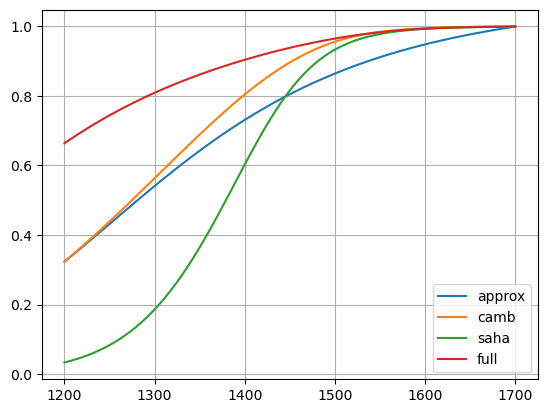

In [7]:
plt.plot(z, X_full,label='approx')
plt.plot(z, cmb,label='camb')
plt.plot(z, saha(z), label='saha')
plt.plot(z, slow, label='full')
plt.grid()
plt.legend()
plt.show()

In [15]:
trunc = np.linspace(800, 1200, 100)
review_fit = rev_ex(trunc)
approx, z = solve(no_photo, saha(1700), 1700, 800, 1000, True)
full = solve(X_diff, saha(1700), 1700, 800, 1000, False)
vol3 = solve(X_vol3, saha(1700), 1700, 800, 1000, False)
cmb = data.get_background_redshift_evolution(z, ['x_e'], format='array')

In [10]:
#approx, z = solve(X_diff, 0.05, 1000, 1400, 1000, True, True)
#full = solve(X_diff, saha(800), 800, 1400, 10000, False, False)
#vol3 = solve(X_vol3, saha(800), 800, 1400, 10000, False)
#back_ev = data.get_background_redshift_evolution(z, ['x_e', 'visibility'], format='array')
#cmb = back_ev[:,0]

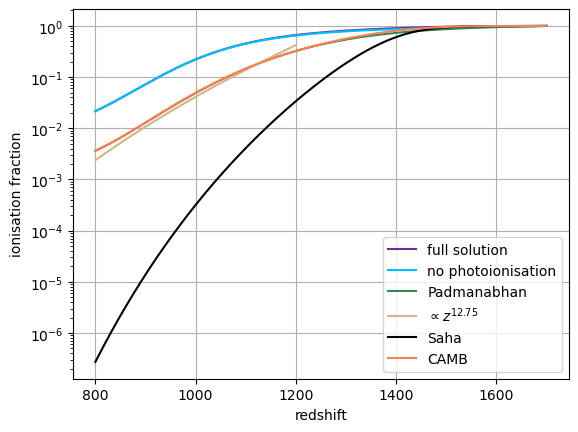

In [17]:
plt.plot(z, full, label='full solution', color='rebeccapurple')
plt.plot(z, approx, label='no photoionisation', color='deepskyblue')
plt.plot(z, vol3, label='Padmanabhan', color='seagreen')
plt.plot(trunc, review_fit, label='$\propto z^{12.75}$', color='tan')
plt.plot(z, saha(z), label='Saha',color='k')
plt.plot(z, cmb, label='CAMB', color='coral')
plt.legend()
plt.grid()
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
#plt.yscale('log')
plt.savefig('Images/X solutions.png', dpi=300)
plt.show()